# Sequence Classification using Recurrent Neural Networks(RNN)
In this homework, you will learn how to train a recurrent neural network for human action classification. RNN is designed handle sequential data. The network can incorporate both past history and current input. [This](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a very good tutorial. You should read it before you start.

## Setup
**Please make sure you have h5py and torchnet installed**
> pip install h5py

> pip install git+https://github.com/pytorch/tnt.git@master

## Known Windows Issues:
### In case you're getting an error [Read more](https://discuss.pytorch.org/t/brokenpipeerror-errno-32-broken-pipe-when-i-run-cifar10-tutorial-py/6224): 
```python
BrokenPipeError: [Errno 32] Broken pipe
```

>In the dataloader block change Line 39, 42, and 45 num_workers=0 

### In case of error (This should be a CUDA error [Read more](https://discuss.pytorch.org/t/asserterror-in-lstm-layer-on-gpu/8698)):

```python
--> 186             assert param_from.type() == param_to.type()
AssertionError: 
```

**Replace following lines:**
```python
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    ...
    input_sequence_var = Variable(sequence).type(FloatTensor)
    input_label_var = Variable(label).type(LongTensor)
    ...
```
```python
def predict_on_test(model, data_loader):
    ...
        input_sequence_var = Variable(sequence).type(FloatTensor)
    ...
```
** With: **
```python
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    ...
    input_sequence_var = Variable(sequence)
    input_label_var = Variable(label)
    ...
```
```python
def predict_on_test(model, data_loader):
    ...
        input_sequence_var = Variable(sequence)
    ...
```

In [267]:
import os
import numpy as np
import h5py

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as DD
import torchnet as tnt
import matplotlib.pyplot as plt
import torchvision.transforms as T


use_cuda = torch.cuda.is_available()
print('use cuda: %s'%(use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor



use cuda: True


## Dataset
The data we are using is skeleton data, which indicates the 3D locations of body joints. In total, there are 25 body joints. It is collected by Kinect v2. To make it easier, each sequence have same number of frames. You need to classify 10 different actions. There are 4000 training sequences, 800 validation sequences, and 1000 test sequences. Each sequence has 15 frames, each frame is a 75-dimension vector (3*25).

For your convenience, we provide the dataloader for you.


In [2]:
class Dataset(DD.Dataset):
    # subset can be: 'train', 'val', 'test'
    def __init__(self, data_path, subset='train'):
        super(Dataset, self).__init__()
        self.data_path = os.path.join(data_path, '%s_data.h5'%subset)
        self.subset = subset

        with h5py.File(self.data_path) as f:
            self.data = np.array(f['data'])

        if subset != 'test':
            self.label_path = os.path.join(data_path, '%s_label.h5'%subset)
            with h5py.File(self.label_path) as f:
                self.label = np.array(f['label'])

        self.num_sequences = self.data.shape[0]
        self.seq_len = self.data.shape[1]
        self.n_dim = self.data.shape[2]

    def __getitem__(self, index):
        seq = self.data[index]
        if self.subset != 'test':
            label = int(self.label[index])
            sample = {'seq': seq, 'label': label}
        else:
            sample = {'seq': seq}
        return sample

    def __len__(self):
        return self.num_sequences

In [116]:
trSet = Dataset('./data', subset='train')
valSet = Dataset('./data', subset='val')
tstSet = Dataset('./data', subset='test')
transform = T.Compose([T.Normalize(0,1)])

batch_size = 100
trLD = DD.DataLoader(trSet, batch_size=batch_size,
       sampler=DD.sampler.RandomSampler(trSet),
       num_workers=2, pin_memory=True)
valLD = DD.DataLoader(valSet, batch_size=batch_size,
       sampler=DD.sampler.SequentialSampler(valSet),
       num_workers=1, pin_memory=True)
tstLD = DD.DataLoader(tstSet, batch_size=batch_size,
       sampler=DD.sampler.SequentialSampler(tstSet),
       num_workers=1, pin_memory=True)

input_dim = trSet.n_dim
num_class = 10

## Model
Pytorch has implemented different types of recurrent layers for you. For this homework, you can use any type of RNNs as you want:
> torch.nn.RNN()

> torch.nn.LSTM()

> torch.nn.GRU()

You can check details for different types of recurrent layers here: [RNN](http://pytorch.org/docs/master/nn.html#torch.nn.RNN), [LSTM]( http://pytorch.org/docs/master/nn.html#torch.nn.LSTM), [GRU](http://pytorch.org/docs/master/nn.html#torch.nn.GRU)


### Implement a specific model
In this section, you need to implement a model for sequence classification. The model has following layers:
* 1 Layer LSTM layer with hidden size of 100, and input size of 75
* A linear layer that goes from 100 to num_class (10). 

An LSTM layer takes an input of size of (batch_size, seq_len, fea_dim) and outputs a variable of shape (batch_size, seq_len, hidden_size). In this homework, the classification score for a sequence is the classification score for the last step of rnn_outputs.



In [270]:
# sequence classification model
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()
        
        ############## 1st To Do (20 points) ##############
        ###################################################
        self.recurrent_layer = nn.LSTM(75,100)
        self.classify_layer = nn.Linear(100,10)
        ###################################################
    
    # the size of input is [batch_size, seq_len(15), input_dim(75)]
    # the size of logits is [batch_size, num_class]
    def forward(self, input, h_t_1=None, c_t_1=None):
        # the size of rnn_outputs is [batch_size, seq_len, rnn_size]
        rnn_outputs, (hn, cn) = self.recurrent_layer(input)
        # classify the last step of rnn_outpus
        # the size of logits is [batch_size, num_class]
        logits = self.classify_layer(rnn_outputs[:,-1])
        return logits

model = SequenceClassify().cuda()

## Train the model
After you have the dataloader and model, you can start training the model. Define a SGD optimizer with learning rate of 1e-2, and a cross-entropy loss function:

In [271]:
################ 2nd To Do  (5 points)##################
optimizer = torch.optim.SGD(model.parameters(),lr=1e-2)
criterion = torch.nn.CrossEntropyLoss().cuda()

In [29]:
# run the model for one epoch
# can be used for both training or validation model
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None,scheduler=None,log = []):
    if is_training:
        model.train()
        logger_prefix = 'train'
    else:
        model.eval()
        logger_prefix = 'val'

    confusion_matrix = tnt.meter.ConfusionMeter(num_class)
    acc = tnt.meter.ClassErrorMeter(accuracy=True)
    meter_loss = tnt.meter.AverageValueMeter()

    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        label = sample['label']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        input_label_var = Variable(label).type(LongTensor)
        
        if use_cuda:
            input_sequence_var.cuda().type(gpu_dtype)
            input_label_var.cuda().long()
        # compute output
        # output_logits: [batch_size, num_class]
        output_logits = model(input_sequence_var)
        loss = criterion(output_logits, input_label_var)

        if is_training:
            optimizer.zero_grad()
            loss.backward()
#             _, l = run_epoch(valLD, model, criterion, e, False, None,log=val_loss)
            optimizer.step()
#             scheduler.step()

        meter_loss.add(loss.data[0])
        acc.add(output_logits.data, input_label_var.data)
        confusion_matrix.add(output_logits.data, input_label_var.data)
    if e +1 == num_epochs:
        print(confusion_matrix.conf)


    print('%s Epoch: %d  , Loss: %.4f,  Accuracy: %.2f'%(logger_prefix, epoch, meter_loss.value()[0], acc.value()[0]))
    log.append(meter_loss.value()[0])
    return acc.value()[0], meter_loss.value()[0]

## Advanced model

In [262]:
# sequence classification model
class ActionModel(nn.Module):
    def __init__(self):
        super(ActionModel, self).__init__()
#         self.norm = nn.BatchNorm1d(15)
        self.recurrent_layer = nn.LSTM(75,200,num_layers = 3,dropout=0.5,bidirectional=True,batch_first=True)
        self.r2 =  nn.LSTM(75,50,num_layers=3,dropout=0.2, bidirectional=False,batch_first= True)
#         self.r3 = nn.LSTM(150,60, num_layers=1,bidirectional=True)
#         self.l1 = nn.Linear(512,10)
#         self.classify_layer = nn.Linear(100,10)
#         self.softmax = nn.LogSoftmax()
        self.classify_layer = nn.Sequential(
#             nn.BatchNorm1d(400),
            nn.Linear(450,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128,10))
#             nn.LogSoftmax())
        
    # the size of input is [batch_size, seq_len(15), input_dim(75)]
    # the size of logits is [batch_size, num_class]
    def forward(self, input, h_t_1=None, c_t_1=None):
        # the size of rnn_outputs is [batch_size, seq_len, rnn_size]
#         input = self.norm(input)
        rnn_outputs, (hn, cn) = self.recurrent_layer(input)
        r2, (hn, cn) = self.r2(input)
        rnn_outputs = torch.cat((rnn_outputs,r2),2)
        
#         rnn_outputs, (hn, cn) = self.r3(rnn_outputs)
        # classify the last step of rnn_outpus
        # the size of logits is [batch_size, num_class]
#         import ipdb;ipdb.set_trace()
        logits = self.classify_layer(rnn_outputs[:,-1])
#         logits = self.classify_layer(logits)
#         logits = self.softmax(logits)
        
        return logits

model = ActionModel()

model = model.cuda()
train_loss = []
val_loss = []

In [263]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=5,factor=0.1,verbose=True,min_lr=5e-5)
criterion = torch.nn.CrossEntropyLoss().cuda()
gpu_dtype = torch.cuda.FloatTensor
use_cuda=True

/home/faizaan09/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


train Epoch: 0  , Loss: 2.1347,  Accuracy: 23.32
val Epoch: 0  , Loss: 2.1005,  Accuracy: 35.38


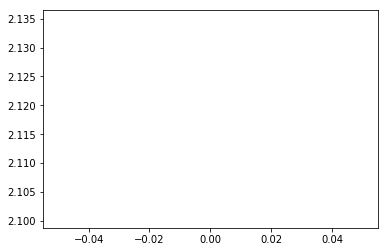

train Epoch: 1  , Loss: 1.5309,  Accuracy: 50.35
val Epoch: 1  , Loss: 1.4336,  Accuracy: 56.38
train Epoch: 2  , Loss: 1.2046,  Accuracy: 59.08
val Epoch: 2  , Loss: 1.2533,  Accuracy: 61.88
train Epoch: 3  , Loss: 1.0546,  Accuracy: 63.47
val Epoch: 3  , Loss: 1.1493,  Accuracy: 66.25
train Epoch: 4  , Loss: 0.9330,  Accuracy: 67.12
val Epoch: 4  , Loss: 1.1242,  Accuracy: 66.00
train Epoch: 5  , Loss: 0.8486,  Accuracy: 70.95
val Epoch: 5  , Loss: 1.0456,  Accuracy: 68.38
train Epoch: 6  , Loss: 0.7726,  Accuracy: 73.83
val Epoch: 6  , Loss: 0.9986,  Accuracy: 69.12
train Epoch: 7  , Loss: 0.7193,  Accuracy: 74.38
val Epoch: 7  , Loss: 0.9449,  Accuracy: 71.75
train Epoch: 8  , Loss: 0.6787,  Accuracy: 76.42
val Epoch: 8  , Loss: 0.9269,  Accuracy: 71.75
train Epoch: 9  , Loss: 0.6314,  Accuracy: 77.60
val Epoch: 9  , Loss: 0.8208,  Accuracy: 75.12
train Epoch: 10  , Loss: 0.6099,  Accuracy: 78.95
val Epoch: 10  , Loss: 0.9269,  Accuracy: 73.50


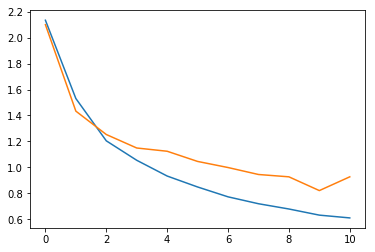

train Epoch: 11  , Loss: 0.5685,  Accuracy: 80.77
val Epoch: 11  , Loss: 0.7887,  Accuracy: 76.25
train Epoch: 12  , Loss: 0.5402,  Accuracy: 81.42
val Epoch: 12  , Loss: 0.7547,  Accuracy: 75.62
train Epoch: 13  , Loss: 0.5113,  Accuracy: 83.02
val Epoch: 13  , Loss: 0.8610,  Accuracy: 72.75
train Epoch: 14  , Loss: 0.4771,  Accuracy: 83.42
val Epoch: 14  , Loss: 0.6945,  Accuracy: 78.50
train Epoch: 15  , Loss: 0.4544,  Accuracy: 84.02
val Epoch: 15  , Loss: 0.7621,  Accuracy: 76.88
train Epoch: 16  , Loss: 0.4420,  Accuracy: 84.12
val Epoch: 16  , Loss: 0.8168,  Accuracy: 78.12
train Epoch: 17  , Loss: 0.4229,  Accuracy: 85.15
val Epoch: 17  , Loss: 0.8229,  Accuracy: 76.62
train Epoch: 18  , Loss: 0.3990,  Accuracy: 86.72
val Epoch: 18  , Loss: 0.7284,  Accuracy: 78.88
train Epoch: 19  , Loss: 0.3718,  Accuracy: 87.12
val Epoch: 19  , Loss: 0.6887,  Accuracy: 79.00
train Epoch: 20  , Loss: 0.3591,  Accuracy: 87.48
val Epoch: 20  , Loss: 0.7267,  Accuracy: 79.00


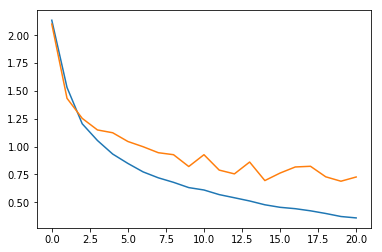

train Epoch: 21  , Loss: 0.3296,  Accuracy: 88.28
val Epoch: 21  , Loss: 0.7606,  Accuracy: 78.88
train Epoch: 22  , Loss: 0.3276,  Accuracy: 88.33
val Epoch: 22  , Loss: 0.9024,  Accuracy: 75.50
train Epoch: 23  , Loss: 0.3290,  Accuracy: 88.83
val Epoch: 23  , Loss: 0.7149,  Accuracy: 79.88
train Epoch: 24  , Loss: 0.3050,  Accuracy: 89.33
val Epoch: 24  , Loss: 0.7001,  Accuracy: 79.62
train Epoch: 25  , Loss: 0.3094,  Accuracy: 89.45
val Epoch: 25  , Loss: 0.7039,  Accuracy: 80.62
Epoch    25: reducing learning rate of group 0 to 1.0000e-04.
train Epoch: 26  , Loss: 0.2054,  Accuracy: 93.23
val Epoch: 26  , Loss: 0.6644,  Accuracy: 82.38
train Epoch: 27  , Loss: 0.1773,  Accuracy: 94.30
val Epoch: 27  , Loss: 0.6633,  Accuracy: 81.88
train Epoch: 28  , Loss: 0.1737,  Accuracy: 94.12
val Epoch: 28  , Loss: 0.6641,  Accuracy: 81.25
[[353   9  21   2   5   0   3   0   0   7]
 [  7 369   4   2  10   0   1   0   0   7]
 [ 25   0 356  13   0   0   0   0   1   5]
 [  7   3  10 366   0   0

In [264]:
num_epochs = 30
evaluate_every_epoch = 1
plot_every_epoch = 10
for e in range(num_epochs):
    run_epoch(trLD, model, criterion, e, True, optimizer,scheduler,log=train_loss)
    if e % evaluate_every_epoch == 0:
        _,l = run_epoch(valLD, model, criterion, e, False, None,log=val_loss)
    
    if e % plot_every_epoch == 0:
        plt.plot(train_loss)
        plt.plot(val_loss)
        plt.show()
    scheduler.step(l)

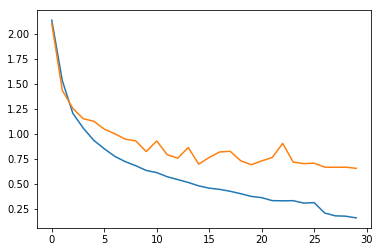

In [265]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

In [258]:
torch.save(model.state_dict(), 'final.pt')

In [ ]:
mymodel = ActionModel()
mymodel.load_state_dict(torch.load('config4.pt'))

In [ ]:
mymodel

## Submit your results on Kaggle

### Train a better model for action recognition!
Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves better accuracy on the action recognition validation set.


### Testing the model and submit on Kaggle
Testing the model on the testing set and save the results as a .csv file. 
Please submitted the results.csv file generated by predict_on_test() to Kaggle(https://www.kaggle.com/c/cse512springhw5) to see how well your network performs on the test set. 
################ 3rd To Do  (30 points, the highest 3 entries get extra 10 points) ###############

In [259]:
# Use your best model to generate results on test set.

# generate csv file for test set
def predict_on_test(model, data_loader):
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    results=open('results.csv','w')
    count=0
    results.write('Id'+','+'Class'+'\n')
    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        scores = model(input_sequence_var)
        _, preds = scores.data.max(1)
        for i in range(len(preds)):
            results.write(str(count)+','+str(preds[i].cpu().item())+'\n')
            count+=1
    results.close()
    return count

count=predict_on_test(model, tstLD)
print(count)

1000


## Report the performance
################ 4th To Do  (15 points)##################

### Documentation of what you did
In this cell, you should write an explanation of what you did (network architecture, optimiziter, learning rate, epoches) and visualizations or graphs of loss/accuracy curve tin the process of training and evaluating.

### Architecture:

The input is sent to 2 parallely running LSTM layers with the config:
1. 200 nodes, 3 stacked layers, dropout=0.5, bidirectional=True
2. 50 nodes, stacked layers=3, dropout=0.2, bidirectional=False
The output of these two layers is concatenated into a 450 dimension vector and passed on to 2 FC layers, separated by a BatchNorm layer and a Leaky Relu activation layer.


### Optimizer:
Adam optimizer was found to be converging the best for this problem. There was a recent paper in ICLR 2018 (https://openreview.net/forum?id=ryQu7f-RZ) that proved there was an error in the original proof of Adam and the author's suggested a new optimizer called AMSGrad. This is availale in PyTorch as a hyperparameter of the Adam optimizer. AMSGrad version of Adam was used in this implementation

### Learning rate:
It was observed that while the loss was initially decreasing for both training and testing sets, after a certain epochs that validation loss either reaches a plateau or increases while the model starts overfitting on the training data. To solve this problem we start with a learning rate of 1e-3 but use an lr_scheduler to tweak the learning rate while training. The specific scheduler used was "ReduceLROnPlateau" which takes the validation loss as input and when the validation loss doesn't reduce for 5 epochs, it multiplies the learning rate by 0.1, to avoid overfitting.


### Epochs:
After 30 training epochs, we achieve 92.77% accuracy on training data and 83.00% accuracy on validation data. The loss vs. epochs plot looks like this.

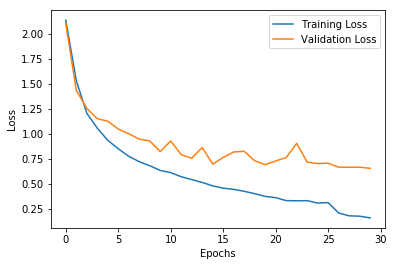

In [266]:
tl = plt.plot(train_loss,label = "Training Loss")
vl = plt.plot(val_loss, label = "Validation Loss")
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### performance on Kaggle
You should also report your Kaggle Performance here: 82.4% (Rank 12 at 10:45 pm)